# Drifting Gratings

Download the Allen data to get started. May take a sec

In [165]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import pprint

# This class uses a 'manifest' to keep track of downloaded data and metadata.  
# All downloaded files will be stored relative to the directory holding the manifest
# file.  If 'manifest_file' is a relative path (as it is below), it will be 
# saved relative to your working directory.  It can also be an absolute path.
boc = BrainObservatoryCache()

In [166]:
# Download experiment containers for VISp experiments
visp_ecs = boc.get_experiment_containers(targeted_structures=['VISp'])
print("all VISp experiment containers: %d" % len(visp_ecs))

all VISp experiment containers: 216


 Get cells of interest (direction selective, drifitng gratings stim)

In [167]:
import pandas as pd

# Download cells for a set of experiments and convert to DataFrame
cells = boc.get_cell_specimens()
cells = pd.DataFrame.from_records(cells)
print("total cells: %d" % len(cells))

# find direction selective cells in VISp
visp_ec_ids = [ ec['id'] for ec in visp_ecs ]
visp_cells = cells[cells['experiment_container_id'].isin(visp_ec_ids)]
print("VISp cells: %d" % len(visp_cells))

# significant response to drifting gratings stimulus
sig_cells = visp_cells[visp_cells['p_dg'] < 0.05]
print("cells with sig. response to drifting gratings: %d" % len(sig_cells))

# direction selective cells
dsi_cells = sig_cells[(sig_cells['g_dsi_dg'] > 0.9)]
print("direction-selective cells: %d" % len(dsi_cells))


total cells: 63251
VISp cells: 22641
cells with sig. response to drifting gratings: 13401
direction-selective cells: 1159


In [168]:
import allensdk.brain_observatory.stimulus_info as stim_info

# find experiment containers for those cells
dsi_ec_ids = dsi_cells['experiment_container_id'].unique()
print("total dsi experiment containers: %d" % len(dsi_ec_ids))

# Download the ophys experiments containing the drifting gratings stimulus for VISp experiment containers
dsi_exps = boc.get_ophys_experiments(experiment_container_ids=dsi_ec_ids, stimuli=[stim_info.DRIFTING_GRATINGS])
print("VISp drifting gratings ophys experiments: %d" % len(dsi_exps))

total dsi experiment containers: 104
VISp drifting gratings ophys experiments: 104


Import required packages for code

In [169]:
from matplotlib import pyplot as plt
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import numpy as np

def plot_stimulus_table(stim_table, title):
    fstart = stim_table.start.min()
    fend = stim_table.end.max()
    
    fig = plt.figure(figsize=(15,1))
    ax = fig.gca()
    for i, trial in stim_table.iterrows():    
        x1 = float(trial.start - fstart) / (fend - fstart)
        x2 = float(trial.end - fstart) / (fend - fstart)            
        ax.add_patch(patches.Rectangle((x1, 0.0), x2 - x1, 1.0, color='r'))
    ax.set_xticks((0,1))
    ax.set_xticklabels((fstart, fend))
    ax.set_yticks(())
    ax.set_title(title)
    ax.set_xlabel("frames")


 Functions

In [194]:
# freq: temporal frequency of stimulus
# ori: orientation of stimulus
# dsi_cell: NWB file for cell
# data_set:  ophys experiment data
# print_graphs: boolean value, if true, plots all of the 15 trials for each stim
# plot_stim_instances: boolean value, if true, shows a plot of the frames each stim is shown
# plot_avg_graph: boolean value, if true, shows average plot of each stim 
# ori_ind: indice of orientation axis for subplots
# freq_ind: indice of frequency axis for subplots
# axs: subplot object
def plot_dg(freq, ori, dsi_cell, data_set, print_graphs, plot_stim_instances, plot_avg_graph, freq_ind, ori_ind,
           axs):
    
    # get flourescence info
    dsi_cell_id = dsi_cell['cell_specimen_id']
    time, dff_traces = data_set.get_dff_traces(cell_specimen_ids=[dsi_cell_id])
    
    # this is a pandas DataFrame. find trials with a given stimulus condition.
    # 40 diff total conditions
    temporal_frequency = freq
    orientation = ori
    stim_table = data_set.get_stimulus_table('drifting_gratings')
    stim_table = stim_table[(stim_table.temporal_frequency == temporal_frequency) & 
                            (stim_table.orientation == orientation)]
    
    # plot of instances of stimulus frames
    if (plot_stim_instances) :
        plot_stimulus_table(stim_table, "Instances of Stimuli, TF %d ORI %d" % (temporal_frequency, orientation))
        plt.show()
    
    list_of_f = [ [0]*120 for i in range(15)] # make 2D array of 120 data points for each of the 15 trials
    x=0
    
    # plot 15 fluorescence graphs
    for start_ind in stim_table.start:
        axs[freq_ind,ori_ind].plot(time[:len(dff_traces[0])][start_ind-30:start_ind+90]-time[start_ind-30], 
                     dff_traces[0][start_ind-30:start_ind+90],color='tan')
        if (print_graphs):
            plt.plot(time[:len(dff_traces[0])][start_ind-30:start_ind+90]-time[start_ind-30], 
                     dff_traces[0][start_ind-30:start_ind+90],color='tan')
            plt.title("Fluorescence from frames %d to %d. Stimuli, TF %d ORI %d" % (start_ind-30,start_ind+90,
                                                                                temporal_frequency, orientation))
            plt.xlabel("seconds")
            plt.ylabel("dF/F")

            # Shade the area of the stimulus
            plt.fill_between(time[:len(dff_traces[0])][start_ind+30:start_ind+90]-time[start_ind], -0.21, -0.2,
                facecolor="orange", # The fill color
                color='blue',       # The outline color
                alpha=0.4)          # Transparency of the fill

            plt.show()
        
        list_of_f[x] = dff_traces[0][start_ind-30:start_ind+90]
        x+=1
    
    # calculate and plot the average response of all graphs
    mean_dff = np.mean((list_of_f[0],list_of_f[1],list_of_f[2],list_of_f[3],list_of_f[4],list_of_f[5],list_of_f[6]
                 ,list_of_f[7],list_of_f[8],list_of_f[9],list_of_f[10],list_of_f[11],list_of_f[12],list_of_f[13],
                 list_of_f[14]), axis=0)
    
    if (plot_avg_graph) :
        axs[freq_ind,ori_ind].plot(time[:len(dff_traces[0])][0:120]-time[0],mean_dff, color='black')
        axs[freq_ind,ori_ind].set_title("TF %d ORI %d" %(temporal_frequency, orientation))
        axs[freq_ind,ori_ind].fill_between(time[:len(dff_traces[0])][start_ind+30:start_ind+90]-time[start_ind], 
                -0.21, -0.2,
                facecolor="orange", # The fill color
                color='blue',       # The outline color
                alpha=0.4)          # Transparency of the fill
    
    # calculate single value average dff from average graph
    return np.mean(mean_dff)
    

In [195]:
# index: index of cell in vector of filtered direction selective cells
# plot_trial_graphs: boolean value, if true, shows all of the 15 trials for each stim
# plot_stim_instances: boolean value, if true, shows a plot of the frames each stim is shown
# plot_avg_graph: boolean value, if true, shows average plot of each stim 
def dg_for_cell(index, plot_trial_graphs, plot_stim_instances, plot_avg_graph): 
    # pick a direction-selective cell and find its NWB file
    dsi_cell = dsi_cells.iloc[index]
    
    # figure out which ophys experiment has the drifting gratings stimulus for that cell
    cell_exp = boc.get_ophys_experiments(cell_specimen_ids=[dsi_cell['cell_specimen_id']],
                                         stimuli=[stim_info.DRIFTING_GRATINGS])[0]

    data_set = boc.get_ophys_experiment_data(cell_exp['id'])
    
    print("Metadata from NWB file:")
    pprint.pprint(data_set.get_metadata())
    
    # initialize stim_matrix
    stim_matrix = [[0]*8 for i in range(5)]
    
    # initialize avg graph subplots
    fig, axs = plt.subplots(5, 8, figsize=(15,15))
    fig.suptitle('Average Fluorescence For Each Stim')
    
    # make subplots and calculate average dff for each stim
    freq_array = [1,2,4,8,15]
    ori_array = [0,45,90,135,180,225,270,315]
    freq_ind = 0
    for freq in freq_array :
        ori_ind = 0
        for ori in ori_array :
            avg_dff = plot_dg(freq, ori, dsi_cell, data_set, plot_trial_graphs, plot_stim_instances, 
                              plot_avg_graph, freq_ind, ori_ind, axs)
            stim_matrix[freq_ind][ori_ind] = avg_dff
            ori_ind +=1
        freq_ind += 1
    
    for ax in axs.flat:
        ax.set(xlabel='sec', ylabel='dF/F')
    for ax in axs.flat:
        ax.label_outer()

    
    # print stim_matrix
    row_labels = ['1', '2', '4', '8', '15']
    column_labels = ['0','45','90','135','180','225','270','315']
    print(pd.DataFrame(stim_matrix, columns=column_labels, index=row_labels))
    
    # calc R max val in stim_matrix
    Rmax = np.amax(stim_matrix)
    print("Cell has Rmax of %f" % Rmax)
    result = np.where(stim_matrix == np.amax(stim_matrix))
    max_coor = list(zip(result[0], result[1]))
    print("At temporal frequency of %d and orientation of %d" % 
          (freq_array[max_coor[0][0]], ori_array[max_coor[0][1]]))
    
    # calc R orth
    Rorth = (stim_matrix[max_coor[0][0]][max_coor[0][1]-2] + stim_matrix[max_coor[0][0]][(max_coor[0][1]+2)%8])/2
    print("Rorth: %f" % Rorth)
    
    # calc OSI
    OSI = (Rmax - Rorth)/(Rmax + Rorth)
    print("OSI: %f" % OSI)

Tests

Metadata from NWB file:
{'age_days': 103,
 'cre_line': 'Cux2-CreERT2/Cux2-CreERT2',
 'device': 'Nikon A1R-MP multiphoton microscope',
 'device_name': 'CAM2P.2',
 'excitation_lambda': '910 nanometers',
 'experiment_container_id': 524691282,
 'fov': '400x400 microns (512 x 512 pixels)',
 'genotype': 'Cux2-CreERT2/Cux2-CreERT2;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/Ai93(TITL-GCaMP6f)',
 'imaging_depth_um': 275,
 'indicator': 'GCaMP6f',
 'ophys_experiment_id': 524691284,
 'pipeline_version': '3.0',
 'session_start_time': datetime.datetime(2016, 6, 20, 13, 41, 30),
 'session_type': 'three_session_A',
 'sex': 'female',
 'specimen_name': 'Cux2-CreERT2;Camk2a-tTA;Ai93-243293',
 'targeted_structure': 'VISp'}
           0        45        90       135       180       225       270  \
1   0.019177  0.030747  0.030514  0.006812  0.013050  0.108105  0.001483   
2   0.015179  0.165179  0.026128  0.002952  0.021670  0.021921 -0.000357   
4   0.004470  0.284808 -0.002431  0.001684  0.014279  0.001210  0.002

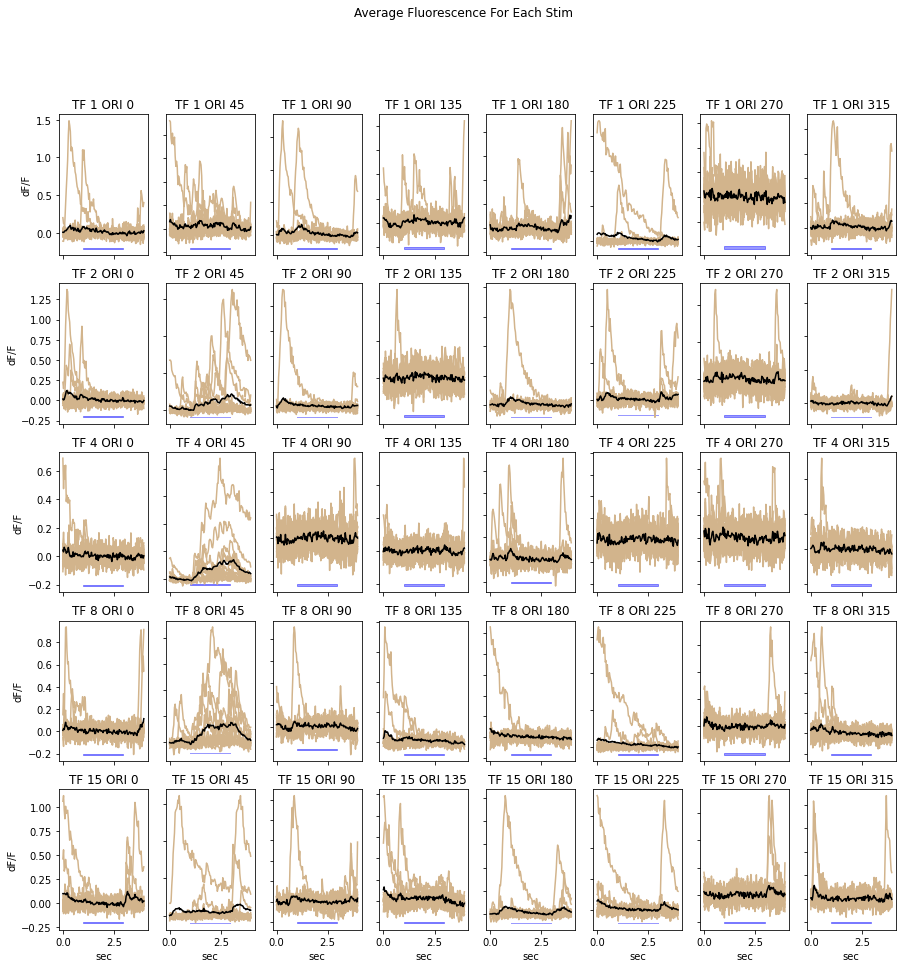

In [196]:
dg_for_cell(304, False, False, True)
